In [1]:
import pm4py
import pandas as pd

attribute_key = "Age:1"
case_id_key = "case:concept:name"

case_attribute_key = f'case:{attribute_key}'

In [4]:
log = pm4py.read_xes('logs/BPI_Challenge_2019.xes')

parsing log, completed traces ::  23%|██▎       | 7115/31509 [00:40<02:17, 177.12it/s] 


KeyboardInterrupt: 

In [20]:
df = pm4py.convert_to_dataframe(log)
df = df.dropna(subset=[case_attribute_key]).reset_index() # filter empty rows

In [21]:
pm4py.get_stochastic_language(df)

{('inwend.geneesk.  korte kaart kosten-out',
  '1e consult poliklinisch',
  'administratief tarief       - eerste pol',
  'verlosk.-gynaec. korte kaart kosten-out',
  'vervolgconsult poliklinisch',
  'administratief tarief       - eerste pol',
  'vervolgconsult poliklinisch',
  'ligdagen - alle spec.beh.kinderg.-reval.',
  'aanname laboratoriumonderzoek',
  'aanname laboratoriumonderzoek',
  'aanname laboratoriumonderzoek',
  'creatinine - spoed',
  'ijzer',
  'natrium - vlamfotometrisch - spoed',
  'kalium vlamfotometrisch - spoed',
  'foliumzuur mbv radioisotopen',
  'vitamine b12 mbv chemieluminescentie',
  'bloedgroep abo en rhesusfactor',
  'rhesusfactor d - centrifugeermethode - e',
  'differentiele telling automatisch',
  'haemoglobine foto-electrisch - spoed',
  'trombocyten tellen - spoed',
  'reticulocyten tellen mbv facscan',
  'cde fenotypering',
  'bloedgroepantigenen andere dan abo-rhesu',
  'kruisproef volledig -drie methoden-',
  'kruisproef volledig -drie methoden-',
 

In [22]:
def uEMSC(l, m):
    return 1 - sum([ max(pr - (m.get(tr) or 0), 0) for tr, pr in l.items() if pr > 0 ])

In [23]:
def Gini(l, m):
    n1 = len(l)
    n2 = len(m)
    n = n1 + n2
    return (n1/n) * (1 - sum([ pr**2 for pr in l.values() ])) + (n2/n) * (1 - sum([ pr**2 for pr in m.values() ]))

In [24]:
attribute_values = pm4py.get_trace_attribute_values(df, attribute_key)

for idx, pivot in enumerate(attribute_values.keys()):

    groups = df.groupby(lambda i: df.loc[i][f'case:{attribute_key}'] < pivot)

    df_lt = groups.get_group(True)
    df_gte = groups.get_group(False)

    stochastic_language_lt = pm4py.get_stochastic_language(df_lt)
    stochastic_language_gte = pm4py.get_stochastic_language(df_gte)

    # emd = pm4py.compute_emd(stochastic_language_lt, stochastic_language_gte)
    emd = 1 - uEMSC(stochastic_language_lt, stochastic_language_gte)

    print(f'[{idx}/{len(attribute_values)}]: {emd}')
    break

[0/69]: 0.9421508316245167


## possible enhancements
If `attribute_values` are ordered by values rather than occurrence frequency,  
size of group `df_lt` would monotonically increase, whereas  
size of group `df_gte` would monotonically decrease.  

This enables quicker regrouping by only applying the `< pivot` condition on the `df_gte` group from the previous iteration.  
The resulting set of traces are the traces that were affected by the pivot shift. All other traces are not affected.  
In particular, this means that for the remaining traces, the stochastic language does not need to be recomputed.  

In [25]:
attribute_values = pm4py.get_trace_attribute_values(df, attribute_key)
sorted_attribute_values = sorted([ float(k) for k in attribute_values.keys() ])

case_attribute_key = f'case:{attribute_key}'

# group df by case ids
grouped = df.filter([case_id_key, case_attribute_key]).groupby(case_id_key, sort=False)
df_gte_light = grouped.first() # initial gte group

for idx, pivot in enumerate(sorted_attribute_values[1:]):

    # shrink gte group by cases where attribute >= pivot
    df_gte_light = df_gte_light[df_gte_light[case_attribute_key] >= pivot]

    # translate light df into full gte & lt groups
    df_gte = pd.concat([ df.loc[grouped.indices[i]] for i in df_gte_light.index ])
    df_lt = df.drop(df_gte.index)

    stochastic_language_lt = pm4py.get_stochastic_language(df_lt)
    stochastic_language_gte = pm4py.get_stochastic_language(df_gte)

    emd = 1 - uEMSC(stochastic_language_lt, stochastic_language_gte)

    print(f'[{idx}/{len(attribute_values) - 1}]: {emd}')
    break

[0/68]: 1.0


In [36]:
case_attribute_key = f'case:{attribute_key}'

attribute_values = pm4py.get_trace_attribute_values(df, attribute_key)
sorted_attribute_values = sorted([ float(k) for k in attribute_values.keys() ])

# group df by case ids
grouped = df.filter([case_id_key, case_attribute_key]).groupby(case_id_key, sort=False)
df_gte_light = grouped.first() # initial gte group

# define absolute languages (counting the occurrence of cases)
# devide absoulte numbers by total number of cases later(!), otherwise every values has to be updated
language_lt = {}
language_gte = pm4py.stats.get_variants(df)

emds = [1.0]
lt_sizes = [0]
gte_sizes = [len(grouped.first().index)]

ginis = []
g1s = []
g2s = []
n1s = []
n2s = []

for idx, pivot in enumerate(sorted_attribute_values[1:]):

    # find affected cases
    df_affected_light = df_gte_light[df_gte_light[case_attribute_key] < pivot]

    # remove affected cases from gte group
    df_gte_light = df_gte_light.drop(df_affected_light.index)

    # translate into full df
    df_affected = pd.concat([ df.loc[grouped.indices[i]] for i in df_affected_light.index ])

    # update absoulte languages
    for tr, n in pm4py.stats.get_variants(df_affected).items():
        language_lt[tr] = language_lt.setdefault(tr, 0) + n
        language_gte[tr] = language_gte[tr] - n

    language_lt_size = sum(language_lt.values(), 0.0)
    language_gte_size = sum(language_gte.values(), 0.0)

    stochastic_language_lt = { k: v / language_lt_size for k, v in language_lt.items() }
    stochastic_language_gte = { k: v / language_gte_size for k, v in language_gte.items() }

    emd = 1 - uEMSC(stochastic_language_lt, stochastic_language_gte)

    n1 = language_lt_size
    n2 = language_gte_size
    n = n1 + n2
    g1 = (1 - sum([ pr**2 for pr in stochastic_language_lt.values() ])) 
    g2 = (1 - sum([ pr**2 for pr in stochastic_language_gte.values() ]))
    gini = (n1/n) * g1 + (n2/n) * g2

    print(f'[{idx}/{len(attribute_values) - 1}]: (uEMD) {emd} | (Gini) {gini}')
    
    # collect data to plot graph
    emds.append(emd)
    ginis.append(gini)
    n1s.append(n1/n)
    n2s.append(n2/n)
    g1s.append(g1)
    g2s.append(g2)
    lt_sizes.append(language_lt_size)
    gte_sizes.append(language_gte_size)

[0/68]: (uEMD) 1.0 | (Gini) 0.9948852408199114
[1/68]: (uEMD) 1.0 | (Gini) 0.9948797386722321
[2/68]: (uEMD) 1.0 | (Gini) 0.9948769726739409
[3/68]: (uEMD) 1.0 | (Gini) 0.9948741966539172
[4/68]: (uEMD) 0.9999999999999998 | (Gini) 0.9948686143300146
[5/68]: (uEMD) 1.0000000000000002 | (Gini) 0.9948573269937722
[6/68]: (uEMD) 0.9999999999999998 | (Gini) 0.9948516210793115
[7/68]: (uEMD) 1.0000000000000002 | (Gini) 0.9948371710361963
[8/68]: (uEMD) 1.0000000000000004 | (Gini) 0.9948283716069563
[9/68]: (uEMD) 0.9999999999999996 | (Gini) 0.9948134849391581
[10/68]: (uEMD) 0.9999999999999999 | (Gini) 0.9948013722197051
[11/68]: (uEMD) 1.0000000000000002 | (Gini) 0.9947859702704005
[12/68]: (uEMD) 1.0000000000000004 | (Gini) 0.9947670939278805
[13/68]: (uEMD) 0.9960861056751462 | (Gini) 0.9947650785062555
[14/68]: (uEMD) 0.9707345725934635 | (Gini) 0.9948478644902012
[15/68]: (uEMD) 0.9724202626641636 | (Gini) 0.9948256484360176
[16/68]: (uEMD) 0.9645833333333336 | (Gini) 0.9948050005051801

In [27]:
# compute relative frequency of traces with certain attribute values
abs_freq = grouped.first().assign(n=1).groupby([case_attribute_key]).count()["n"].tolist() # get number of traces traces with same attribute value
total = len(grouped.first().index)
rel_freq = [ v / total for v in abs_freq ]

rel_lt_sizes = [ s / total for s in lt_sizes ]
rel_gte_sizes = [ s / total for s in gte_sizes ]

In [28]:
# get 10% & 90% marks

# PROBLEM: if we have a log where not every trace has the attribute in question, then sum(abs_freq) < number_of_traces,
# we should apply a filter here. maybe even to the entire log before processing

alpha = 0.1

bounds_idx = {
    "lower": None, 
    "upper": None
}

target = alpha * total
seen = 0
for (i, freq) in enumerate(abs_freq):
    seen += freq
    if seen >= target:
        bounds_idx["lower"] = i
        break

target = alpha * total
seen = 0
for (i, freq) in reversed(list(enumerate(abs_freq))):
    seen += freq
    if seen >= target:
        bounds_idx["upper"] = i
        break

bounds_idx

{'lower': 14, 'upper': 56}

In [29]:
# sanity check
s = 0
for x in rel_freq[bounds_idx["lower"]:bounds_idx["upper"]]:
    s += x

print(f'% traces in {alpha * 100}-{(1-alpha) * 100} range: {s}')

print(f'rel_lt_sizes at {alpha * 100}% mark: {rel_lt_sizes[bounds_idx["lower"] - 1]} / {rel_lt_sizes[bounds_idx["lower"]]}')
print(f'rel_lt_sizes at {(1 - alpha) * 100}% mark: {rel_lt_sizes[bounds_idx["upper"] - 1]} / {rel_lt_sizes[bounds_idx["upper"]]}')
print(f'rel_gte_sizes at {alpha * 100}% mark: {rel_gte_sizes[bounds_idx["lower"] - 1]} / {rel_gte_sizes[bounds_idx["lower"]]}')
print(f'rel_gte_sizes at {(1 - alpha) * 100}% mark: {rel_gte_sizes[bounds_idx["upper"] - 1]} / {rel_gte_sizes[bounds_idx["upper"]]}')

% traces in 10.0-90.0 range: 0.8096947935368043
rel_lt_sizes at 10.0% mark: 0.07360861759425494 / 0.08258527827648116
rel_lt_sizes at 90.0% mark: 0.8797127468581688 / 0.8922800718132855
rel_gte_sizes at 10.0% mark: 0.926391382405745 / 0.9174147217235189
rel_gte_sizes at 90.0% mark: 0.12028725314183124 / 0.10771992818671454


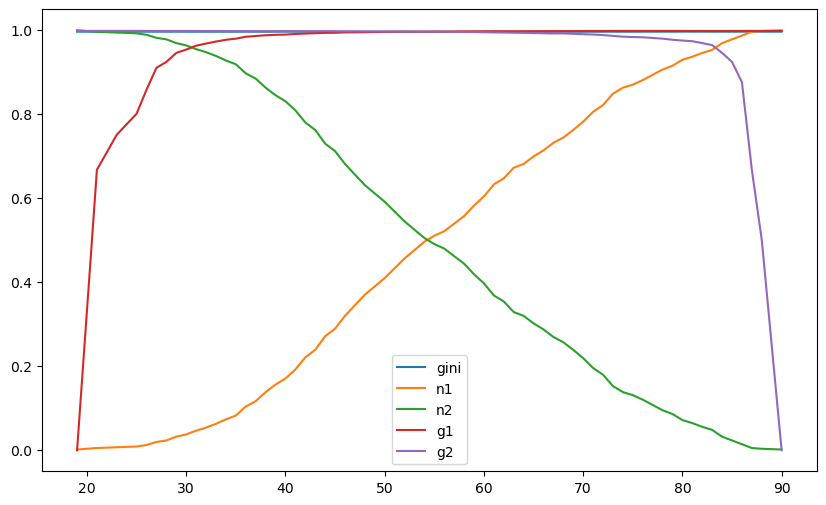

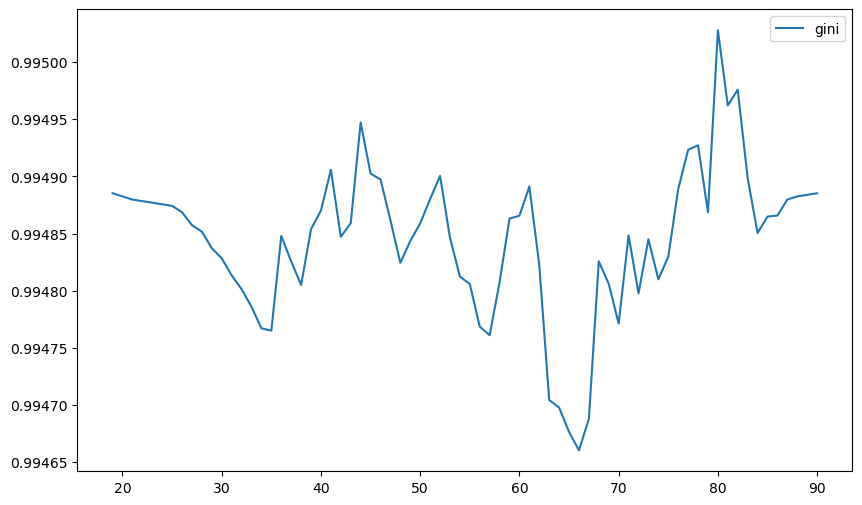

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# plot gini
plt.plot(sorted_attribute_values[1:], ginis, label="gini")

plt.plot(sorted_attribute_values[1:], n1s, label="n1")
plt.plot(sorted_attribute_values[1:], n2s, label="n2")
plt.plot(sorted_attribute_values[1:], g1s, label="g1")
plt.plot(sorted_attribute_values[1:], g2s, label="g2")

plt.legend()

plt.show()

plt.figure(figsize=(10,6))

plt.plot(sorted_attribute_values[1:], ginis, label="gini")


plt.legend()

plt.show()

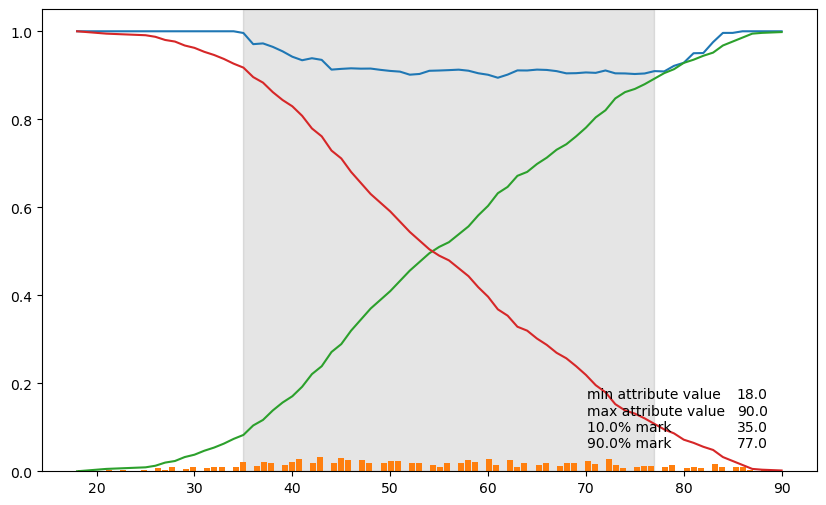

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.axvspan(
    sorted_attribute_values[bounds_idx["lower"]], 
    sorted_attribute_values[bounds_idx["upper"]], 
    color='black', 
    alpha=0.1
)

# plot emd
plt.plot(sorted_attribute_values, emds)

# plot relative frequency
plt.hist(sorted_attribute_values, bins=100, weights=rel_freq, rwidth=0.85)

plt.plot(sorted_attribute_values, rel_lt_sizes)
plt.plot(sorted_attribute_values, rel_gte_sizes)

plt.figtext(0.67, .15, "\n".join([
    "min attribute value",
    "max attribute value",
    f'{alpha * 100}% mark',
    f'{(1 - alpha) * 100}% mark'
]), {'multialignment': 'left'})

plt.figtext(.82, .15, "\n".join([
    f'{sorted_attribute_values[0]}',
    f'{sorted_attribute_values[-1]}',
    f'{sorted_attribute_values[bounds_idx["lower"]]}',
    f'{sorted_attribute_values[bounds_idx["upper"]]}'
]), {'multialignment': 'right'})

plt.show()

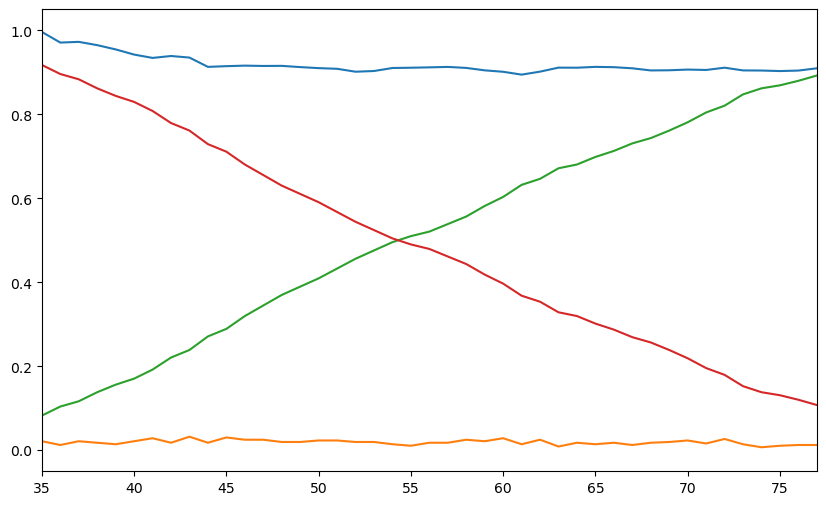

In [32]:
# zoomed in version
plt.figure(figsize=(10,6))

plt.plot(sorted_attribute_values, emds)
plt.plot(sorted_attribute_values, rel_freq)
plt.plot(sorted_attribute_values, rel_lt_sizes)
plt.plot(sorted_attribute_values, rel_gte_sizes)

plt.axis(xmin=sorted_attribute_values[bounds_idx["lower"]], xmax=sorted_attribute_values[bounds_idx["upper"]])
plt.show()

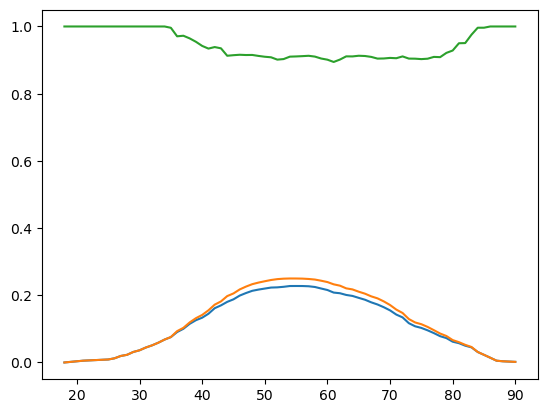

In [33]:
# plt.plot([ emd * s_lt * s_gte for emd, s_lt, s_gte in zip(emds, rel_lt_sizes, rel_gte_sizes) ])
plt.plot(sorted_attribute_values, [ s_lt * s_gte * emd for s_lt, s_gte, emd in zip(rel_lt_sizes, rel_gte_sizes, emds) ])
plt.plot(sorted_attribute_values, [ s_lt * s_gte for s_lt, s_gte in zip(rel_lt_sizes, rel_gte_sizes) ])
plt.plot(sorted_attribute_values, emds)
plt.show()

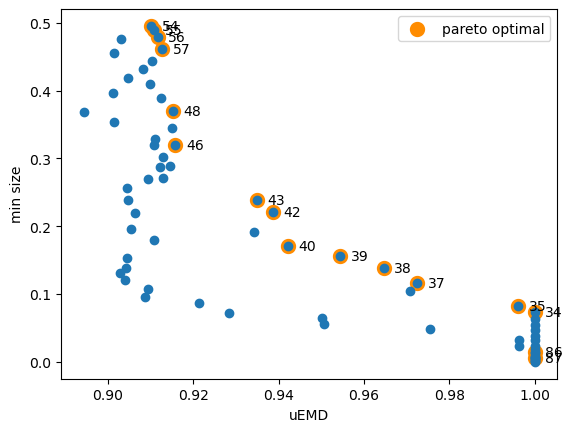

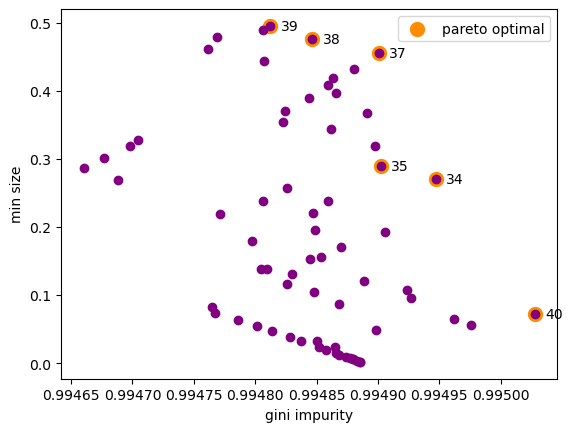

In [110]:
from paretoset import paretoset

sizes = [ min(l, g) for l, g in zip(rel_lt_sizes, rel_gte_sizes) ]

mask = paretoset(pd.DataFrame({
    "emds": emds,
    "sizes": sizes,
}), sense=["max","max"])
pdx, pdy, val = zip(*[ (e, s, v) for e, s, m, v in zip(emds, sizes, mask, sorted_attribute_values) if m ])
pareto_optimal_emd_values = val

fig, ax = plt.subplots()

ax.scatter(pdx, pdy, label="pareto optimal", color="darkorange", linewidths=5)
ax.scatter(emds, sizes)

for x, y, v in zip(pdx, pdy, val):
    ax.annotate(int(v), (x, y), xytext=(0.75, -0.3), textcoords="offset fontsize")

ax.legend()

plt.xlabel("uEMD")
plt.ylabel("min size")
plt.show()

mask = paretoset(pd.DataFrame({
    "ginis": ginis,
    "sizes": sizes[1:],
}), sense=["max","max"])
pdx, pdy = zip(*[ (e, s) for e, s, m in zip(ginis, sizes[1:], mask) if m ])
pareto_optimal_gini_values = val

fig, ax = plt.subplots()

ax.scatter(pdx, pdy, label="pareto optimal", color="darkorange", linewidths=5)
ax.scatter(ginis, sizes[1:], color="purple")

for x, y, v in zip(pdx, pdy, val):
    ax.annotate(int(v), (x, y), xytext=(0.75, -0.3), textcoords="offset fontsize")

ax.legend()

plt.xlabel("gini impurity")
plt.ylabel("min size")
plt.show()